In [333]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import display  # to display variables in a "nice" way
from mpl_toolkits.mplot3d import Axes3D
# pd.options.display.max_rows = 9999
pd.options.display.max_columns = 200

Setting the Random State:

In [334]:
IDs =  [312920,312919,313385]
rs = np.min(IDs)
np.random.seed(rs)

Exercise 1 (Loading and Preparing the Data):

(a)

In [335]:
# PATH TO THE cla4lsp22_bikez_curated.csv FILE
bikez_path = 'cla4lsp22_bikez_curated.csv'

# LOADING THE DATASET AS DATAFRAME then store in the variable df_tot
df_tot = pd.read_csv(bikez_path)

# DISPLAY OF THE DATAFRAME
# display(df_tot)

##### b) Generate x as a random number: 0, 1, or 2. workdf is the dftot containing only data corresponding to years with reminder r resulted by modulus 3

In [336]:
x = int(np.random.uniform(0,3))
workdf = df_tot[df_tot['Year'] % 3 == x]
display(workdf)

,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,Gearbox,Bore (mm),Stroke (mm),Fuel capacity (lts),Fuel control,Cooling system,Transmission type,Dry weight (kg),Wheelbase (mm),Seat height (mm),Fuel system,Front brakes,Rear brakes,Front tire,Rear tire,Front suspension,Rear suspension
3,acabion,gtbo 600 daytona-vi,2021,Prototype / concept model,NaN,NaN,536.0,NaN,Electric,Electric,Not Given/Unknown,NaN,NaN,NaN,Not Given/Unknown,Liquid,Not Given/Unknown,420.0,NaN,NaN,not given/unknown,single disc,single disc,other,other,not given/unknown,not given/unknown
5,access,37 offroad e-scooter,2021,Scooter,NaN,NaN,1.1,NaN,Electric,Electric,Automatic,NaN,NaN,NaN,Not Given/Unknown,Not Given/Unknown,Chain,42.0,NaN,750.0,not given/unknown,single disc,single disc,other,other,not given/unknown,not given/unknown
14,access,amx 8.57 efi,2018,ATV,NaN,781.0,57.7,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,21.0,Overhead Cams (OHC),Liquid,Chain,344.0,NaN,NaN,injection,single disc,single disc,25/8-12,25/10-12,other,other
15,access,minisport 110,2021,ATV,NaN,107.0,6.8,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,NaN,Not Given/Unknown,Air,Chain,95.0,NaN,610.0,not given/unknown,single disc,single disc,other,other,not given/unknown,not given/unknown
16,access,shade 200,2021,ATV,NaN,176.0,13.1,NaN,Single cylinder,four-stroke,Automatic,NaN,NaN,NaN,Overhead Cams (OHC),Air,Chain,201.0,NaN,NaN,not given/unknown,single disc,single disc,other,other,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38455,zündapp,roller super,1964,Scooter,NaN,49.0,NaN,NaN,Single cylinder,two-stroke,Not Given/Unknown,39.0,42.0,NaN,Not Given/Unknown,Air,Not Given/Unknown,83.5,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,other,not given/unknown,not given/unknown
38458,zündapp,roller super,1967,Scooter,NaN,49.0,NaN,NaN,Single cylinder,two-stroke,Not Given/Unknown,39.0,42.0,NaN,Not Given/Unknown,Air,Not Given/Unknown,83.5,NaN,NaN,carburettor. other,expanding brake (drum brake),expanding brake (drum brake),other,other,not given/unknown,not given/unknown
38461,zündapp,z 2 g,1922,Sport,1.5,211.0,2.8,NaN,Single cylinder,two-stroke,2-speed,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,73.0,NaN,NaN,carburettor,not given/unknown,not given/unknown,other,other,other,other
38465,zündapp,z 22,1922,Sport,NaN,211.0,2.3,NaN,Single cylinder,two-stroke,2-speed,62.0,70.0,6.0,Not Given/Unknown,Air,Belt,58.0,NaN,NaN,carburettor,not given/unknown,not given/unknown,other,other,other,other


##### c) Remove randomly from workdf two columns among the features: Front/Rear breaks, Front/Rear tire, Front/Rear suspension.

In [337]:
temp_features = ['Front brakes', 'Rear brakes','Front tire', 'Rear tire','Front suspension', 'Rear suspension']

feat1,feat2 = np.random.choice(temp_features, 2, replace=False)
workdf = workdf.drop(columns=[feat1,feat2])

Denote:
labels: the columns Brand, Model, Year, Category, Rating;
features: all the other ones

In [338]:
labels = workdf.columns[:5].tolist()
features = workdf.columns[5:].tolist()


d) Clean the dataset workdf from missing values in the feature columns (if needed).

##### Show percentage of missing values for each column of workdf

In [339]:
# compute the percentage of NaN values for each column
na_percentage = workdf.isna().mean() * 100
display(na_percentage)

# filter the na_percentage series to only include columns with a percentage of NaN values > 0
na_percentage_filtered = na_percentage[na_percentage > 0]

# subtract the labels list from the list of columns with NaN values > 0
na_features = na_percentage_filtered.index.difference(labels).tolist()

Brand                   0.000000
Model                   0.079789
Year                    0.000000
Category                0.000000
Rating                 42.160696
Displacement (ccm)      2.465491
Power (hp)             31.173701
Torque (Nm)            54.655709
Engine cylinder         0.000000
Engine stroke           0.000000
Gearbox                 0.000000
Bore (mm)              25.412910
Stroke (mm)            25.420889
Fuel capacity (lts)    16.356818
Fuel control            0.000000
Cooling system          0.000000
Transmission type       0.000000
Dry weight (kg)        41.322908
Wheelbase (mm)         33.351951
Seat height (mm)       35.721695
Fuel system             0.000000
Front brakes            0.000000
Rear brakes             0.000000
Rear tire               0.000000
Rear suspension         0.000000
dtype: float64

Remove Nan values from 'Displacement (ccm)' since NaN values are sparse

In [340]:
workdf.dropna(subset=['Displacement (ccm)'], inplace=True)


Fill Nan values from other columns by mean

In [341]:
for col in na_features:
    workdf[col] = workdf[col].fillna(workdf[col].mean())

Exercise 2 (Encoding of Categorical Data):

In [342]:
# select only the string columns in workdf that are in the features list
string_cols = workdf.select_dtypes(include=['object']).columns.intersection(features)

# apply one-hot encoding to the selected string columns
for col in string_cols:
    encoded_cols = workdf[col].str.get_dummies(sep='.').add_prefix(col + '_')
    workdf = pd.concat([workdf, encoded_cols], axis=1)

    # drop the original string column
    workdf.drop(col, axis=1, inplace=True)

# create a new DataFrame without the labels (only features)
Xworkdf = workdf.drop(columns=labels)

# print the updated DataFrame
display(Xworkdf)

,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm),Engine cylinder_Diesel,Engine cylinder_Dual disc Wankel,Engine cylinder_Electric,Engine cylinder_Four cylinder boxer,Engine cylinder_In-line four,Engine cylinder_In-line six,Engine cylinder_In-line three,Engine cylinder_Not Given/Unknown,Engine cylinder_Radial,Engine cylinder_Single cylinder,Engine cylinder_Single disc Wankel,Engine cylinder_Six cylinder boxer,Engine cylinder_Square four cylinder,Engine cylinder_Twin,Engine cylinder_Two cylinder boxer,Engine cylinder_V10,Engine cylinder_V2,Engine cylinder_V3,Engine cylinder_V4,Engine cylinder_V6,Engine cylinder_V8,Engine stroke_ four-stroke,Engine stroke_ two-stroke,Engine stroke_Diesel,Engine stroke_Dual disc Wankel,Engine stroke_Electric,Engine stroke_Not Given/Unknown,Engine stroke_Radial,Engine stroke_Single disc Wankel,Engine stroke_Square four cylinder,Gearbox_1-speed,Gearbox_100-speed,Gearbox_2-speed,Gearbox_2-speed automatic,Gearbox_3-speed,Gearbox_4-speed,Gearbox_4-speed with reverse,Gearbox_5-speed,Gearbox_5-speed with reverse,Gearbox_6-speed,Gearbox_7-speed,Gearbox_8-speed,Gearbox_Automatic,Gearbox_Not Given/Unknown,Fuel control_Desmodromic valve control,Fuel control_Double Overhead Cams/Twin Cam (DOHC),Fuel control_Membrane,Fuel control_Membrane & power valve,Fuel control_Membrane & variable discharge openings,Fuel control_Not Given/Unknown,Fuel control_Overhead Cams (OHC),Fuel control_Overhead Valves (OHV),Fuel control_Port control,Fuel control_Pushrods,Fuel control_Rotary valves,Fuel control_Rotary valves & variable discharge openings,Fuel control_Sidevalves,Fuel control_Single Overhead Cams (SOHC),Fuel control_Standing valves,Cooling system_Air,Cooling system_Liquid,Cooling system_Not Given/Unknown,Cooling system_Oil & air,Transmission type_Belt,Transmission type_Chain,Transmission type_Not Given/Unknown,Transmission type_Shaft drive,Fuel system_ carburettor,Fuel system_ injection,Fuel system_ other,Fuel system_carburettor,Fuel system_efi,Fuel system_injection,Fuel system_not given/unknown,Fuel system_other,Front brakes_ abs,Front brakes_ double disc,Front brakes_ expanding brake (drum brake),Front brakes_ floating discs,Front brakes_ four-piston calipers,Front brakes_ hydraulic,Front brakes_ other,Front brakes_ single disc,Front brakes_ two-piston calipers,Front brakes_abs,Front brakes_brembo,Front brakes_double disc,Front brakes_dual disc,Front brakes_expanding brake,Front brakes_expanding brake (drum brake),Front brakes_floating discs,Front brakes_four-piston calipers,Front brakes_hydraulic,Front brakes_not given/unknown,Front brakes_other,Front brakes_single disc,Front brakes_two-piston calipers,Rear brakes_ abs,Rear brakes_ expanding brake (drum brake),Rear brakes_ floating disc,Rear brakes_ hydraulic,Rear brakes_ other,Rear brakes_ single disc,Rear brakes_ single-piston caliper,Rear brakes_ two-piston calipers,Rear brakes_abs,Rear brakes_brembo,Rear brakes_expanding brake,Rear brakes_expanding brake (drum brake),Rear brakes_floating disc,Rear brakes_hydraulic,Rear brakes_not given/unknown,Rear brakes_other,Rear brakes_single disc,Rear brakes_single-piston caliper,Rear brakes_two-piston calipers,Rear tire_120/70-12,Rear tire_130/60-13,Rear tire_130/70-12,Rear tire_130/70-17,Rear tire_25/10-12,Rear tire_other,Rear suspension_ other,Rear suspension_dual shocks,"Rear suspension_link type, coil spring, oil damped",Rear suspension_monoshock,Rear suspension_not given/unknown,Rear suspension_other,Rear suspension_single shock,Rear suspension_swing arm,Rear suspension_twin shocks
14,781.0,57.700000,64.338609,72.828926,65.319172,21.000000,344.0,1430.145185,787.252128,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
15,107.0,6.

#### Exercise 3 (Preprocessing and PCA): Preprocess the data, before applying the PCA

In [343]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
Xworkdf_std = pd.DataFrame(scaler.fit_transform(Xworkdf), columns=Xworkdf.columns)


In [344]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
Xworkdf_mm = pd.DataFrame(scaler.fit_transform(Xworkdf), columns=Xworkdf.columns)


To compare the variances of the original dataset Xworkdf with the variances of the datasets Xworkdf_std and Xworkdf_mm, we can calculate the variances of the non-categorical features in all three datasets.

Assuming that Xworkdf contains both categorical and non-categorical features, we can select only the non-categorical features as follows:

In [345]:
noncat_features = Xworkdf.select_dtypes(exclude='object').columns

Then, we can calculate the variances of the non-categorical features in all three datasets:

In [346]:
# Calculate variances of non-categorical features in Xworkdf
variances_original = Xworkdf[noncat_features].var()

# Calculate variances of non-categorical features in Xworkdf_std
variances_standardized = Xworkdf_std[noncat_features].var()

# Calculate variances of non-categorical features in Xworkdf_mm
variances_minmax = Xworkdf_mm[noncat_features].var()


Now we can compare the variances of the non-categorical features in the three dataframes. We can plot the variances using a bar plot:

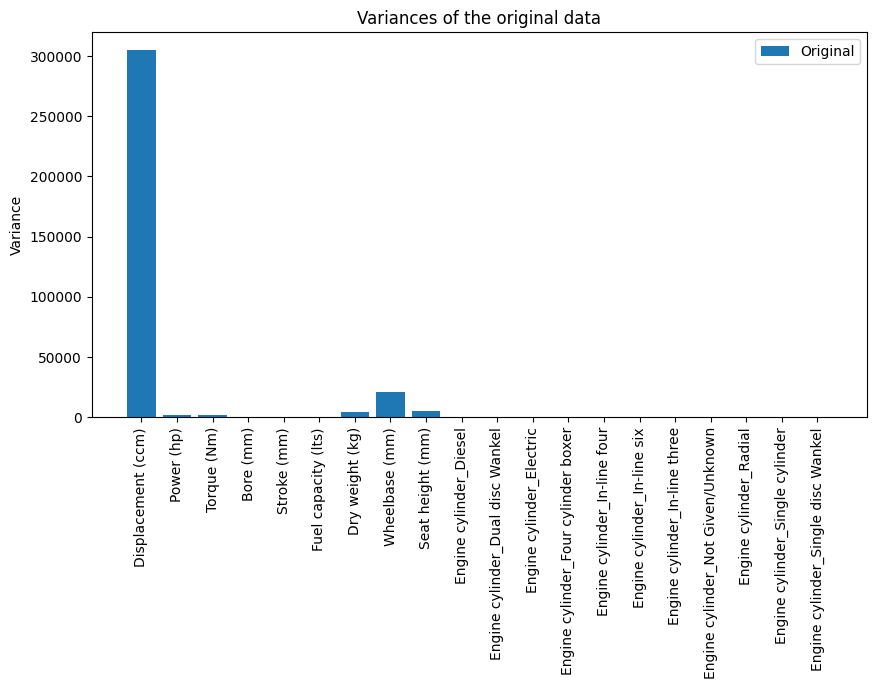

In [347]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Display only the initial 20 characteristics for the sake of legibility as the features are extensive and displaying all of them would be unsuitable.
plt.bar(variances_original[:20].index, variances_original[:20], label='Original')

plt.xticks(rotation=90)
plt.title('Variances of the original data')
plt.ylabel('Variance')
plt.legend()
plt.show()

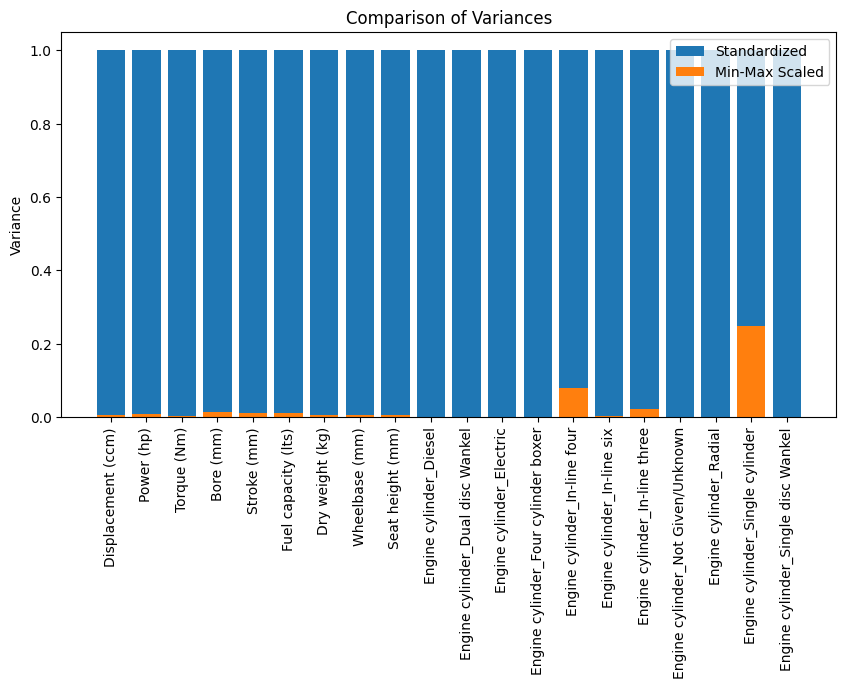

In [348]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Display only the initial 20 characteristics for the sake of legibility as the features are extensive and displaying all of them would be unsuitable.
plt.bar(variances_standardized[:20].index, variances_standardized[:20], label='Standardized')
plt.bar(variances_minmax[:20].index, variances_minmax[:20], label='Min-Max Scaled')
plt.xticks(rotation=90)
plt.title('Comparison of Variances')
plt.ylabel('Variance')
plt.legend()
plt.show()

This will produce two plot with three bars, one for each dataset, with the height of each bar representing the variance of the corresponding non-categorical feature.

From the plots, we can observe that the variances of the non-categorical features are different in the three datasets. Specifically, the variances of the standardized dataset Xworkdf_std are all equal to 1, as expected since this is a property of standardized data. On the other hand, the variances of the min-max scaled dataset Xworkdf_mm are all between 0 and 1, since this is the range specified by the MinMaxScaler. The variances of the original dataset Xworkdf are not normalized, and can be much larger than 1.

Based on this analysis, we can infer that scaling the non-categorical features using either a StandardScaler or a MinMaxScaler can help to ensure that these features are on the same scale and have comparable variances. This can be particularly important for certain machine learning algorithms, such as those that rely on distance-based calculations or regularization, where features with large variances can have a disproportionate impact on the algorithm's performance. However, the choice of scaler may depend on the specific requirements of the problem at hand, and in some cases it may be appropriate to use a different scaler or no scaler at all.

##### Here we use the PCA class from the sklearn.decomposition module to fit a PCA model to each of the three DataFrames, with n_components='mle' to retain all components. We then calculate the cumulative explained variance using the explained_variance_ratio_ attribute of the PCA object, and store the results in three arrays cumulative_variances_original, cumulative_variances_standardized, and cumulative_variances_minmax.

In [349]:
from sklearn.decomposition import PCA

# Create a PCA object with all components
pca = PCA(n_components='mle')

# Fit the PCA model to the original data
pca.fit(Xworkdf)

# Calculate cumulative explained variance
cumulative_variances_original = np.cumsum(pca.explained_variance_ratio_)

# Fit the PCA model to the standardized data
pca.fit(Xworkdf_std)

# Calculate cumulative explained variance
cumulative_variances_standardized = np.cumsum(pca.explained_variance_ratio_)

# Fit the PCA model to the min-max scaled data
pca.fit(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_variances_minmax = np.cumsum(pca.explained_variance_ratio_)


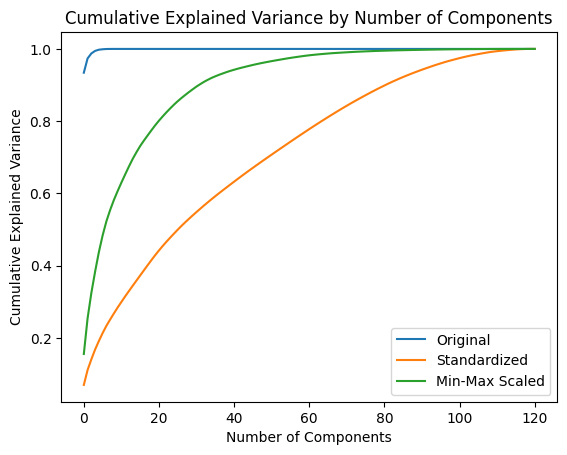

In [350]:
plt.plot(cumulative_variances_original, label='Original')
plt.plot(cumulative_variances_standardized, label='Standardized')
plt.plot(cumulative_variances_minmax, label='Min-Max Scaled')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.legend()
plt.show()

This will produce a plot with three lines, one for each DataFrame, with the x-axis representing the number of components and the y-axis representing the cumulative explained variance.

The original dataset, Xworkdf, has a constant cumulative explained variance of 1, which means that all of the variance in the data is explained by the full set of features. This is expected, as the original dataset has not been transformed or scaled in any way.

The standardized dataset, Xworkdf_std, has a slower increase in cumulative explained variance compared to the min-max scaled dataset, Xworkdf_mm, but still reaches a cumulative variance of 0.9 after approximately 85 principal components and then it reached a cumulative variance of 1 after 110 components. This indicates that standardizing the dataset has reduced the impact of features with large variances, but there are still a large number of principal components required to explain the majority of the variance in the data.

In contrast, the min-max scaled dataset, Xworkdf_mm, has a much faster increase in cumulative explained variance and reaches a cumulative variance of 0.9 after only 25 principal components and then it reached 1 for the 65 components. This suggests that scaling the dataset to a specific range has had a significant impact on reducing the impact of features with large variances, and the majority of the variance in the data can be explained by a smaller number of principal components.

In [351]:
# PCA on Xworkdf_std
pca_std = PCA().fit(Xworkdf_std)
# cumulative sum of explained variance
cum_var_std = np.cumsum(pca_std.explained_variance_ratio_)
# minimum number of PCs to explain 35% of variance
min_pc_std = np.argmax(cum_var_std >= 0.35) + 1
# number of PCs to select
num_pc_std = min(min_pc_std, 5)
# fit PCA with selected number of PCs
pca_std = PCA(n_components=num_pc_std).fit(Xworkdf_std)

In [352]:
# PCA on Xworkdf_mm
pca_mm = PCA().fit(Xworkdf_mm)
# cumulative sum of explained variance
cum_var_mm = np.cumsum(pca_mm.explained_variance_ratio_)
# minimum number of PCs to explain 35% of variance
min_pc_mm = np.argmax(cum_var_mm >= 0.35) + 1
# number of PCs to select
num_pc_mm = min(min_pc_mm, 5)
# fit PCA with selected number of PCs
pca_mm = PCA(n_components=num_pc_mm).fit(Xworkdf_mm)

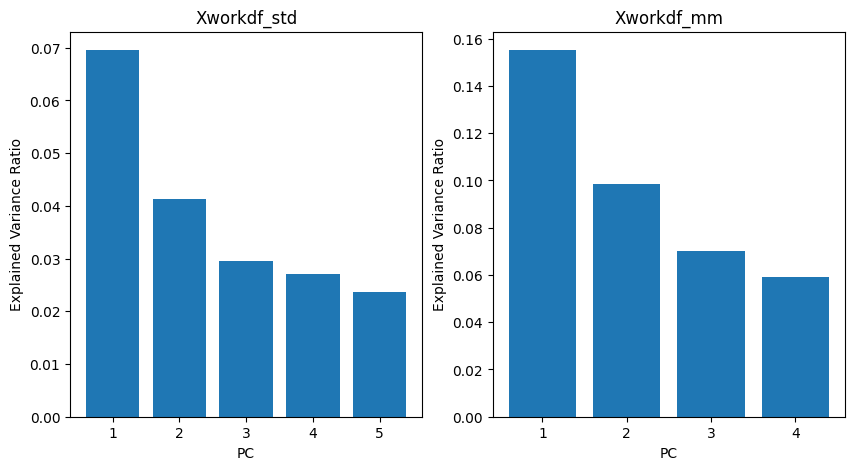

In [353]:
# plot barplots of percentage of explained variance
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(range(1, num_pc_std+1), pca_std.explained_variance_ratio_)
axs[0].set_title('Xworkdf_std')
axs[0].set_xlabel('PC')
axs[0].set_ylabel('Explained Variance Ratio')
axs[1].bar(range(1, num_pc_mm+1), pca_mm.explained_variance_ratio_)
axs[1].set_title('Xworkdf_mm')
axs[1].set_xlabel('PC')
axs[1].set_ylabel('Explained Variance Ratio')
plt.show()

This code first applies PCA to both dataframes using the default number of components. It then calculates the cumulative sum of explained variance and determines the minimum number of PCs required to explain 35% of the total variance. The code then selects the minimum number of PCs or 5, whichever is smaller. Finally, it fits PCA with the selected number of PCs and plots the barplots of the percentage of explained variance for both dataframes.

Interpretation of the PCs - Standard Scaler

In [354]:
# Get the names of the original features
feature_names = Xworkdf.columns.tolist()

# Get the loadings for each principal component
loadings = pca_std.components_

# Get the threshold
eps_std = np.sqrt(1 / pca_std.n_features_)
# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_std][:5]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_std][:5]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
    print()



PC1:
	Displacement (ccm): 0.23
	Power (hp): 0.22
	Torque (Nm): 0.19
	Bore (mm): 0.20
	Stroke (mm): 0.12
	Engine cylinder_Single cylinder: -0.20
	Engine stroke_ two-stroke: -0.14
	Fuel control_Not Given/Unknown: -0.11
	Cooling system_Air: -0.13
	Fuel system_carburettor: -0.15

PC2:
	Displacement (ccm): 0.20
	Power (hp): 0.09
	Torque (Nm): 0.14
	Bore (mm): 0.12
	Stroke (mm): 0.15
	Seat height (mm): -0.09
	Engine cylinder_Single cylinder: -0.21
	Gearbox_Automatic: -0.14
	Fuel control_Single Overhead Cams (SOHC): -0.12
	Cooling system_Liquid: -0.13

PC3:
	Engine cylinder_Twin: 0.10
	Engine stroke_ two-stroke: 0.12
	Fuel control_Port control: 0.11
	Transmission type_Chain: 0.15
	Fuel system_not given/unknown: 0.17
	Displacement (ccm): -0.09
	Stroke (mm): -0.11
	Dry weight (kg): -0.12
	Engine cylinder_V2: -0.09
	Engine stroke_ four-stroke: -0.12

PC4:
	Stroke (mm): 0.23
	Dry weight (kg): 0.12
	Engine cylinder_Two cylinder boxer: 0.10
	Engine cylinder_V2: 0.15
	Engine stroke_ four-stroke: 0.1

/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


Name for each PC:

In [355]:
# LIST OF THE NAMES ASSIGNED TO THE PCs - Standard Scaler
pc_std_names = ['Engine size and type',
           'Fuel system and transmission type',
           'Fuel control type',
           ]

Interpretation for PC1: The first principal component is mainly related to engine size and type. The top positive loadings are for displacement, power, bore and torque, which are all engine-related features. The top negative loadings are for some engine-related features as well, such as engine cylinder and fuel system. This PC seems to capture the overall engine size and type, where higher values correspond to larger and more powerful engines, while lower values correspond to smaller and less powerful ones.

Interpretation for PC2: The second principal component is mainly related to the fuel system and transmission type. The top positive loadings are for displacement and stroke, while the top negative loadings are for some features related to the fuel system, such as fuel control and cooling system, and the transmission type. This PC seems to capture the difference between motorcycles with carburetors and those with more modern fuel injection systems, as well as those with manual and automatic transmissions.

Interpretation for PC3: The third principal component is mainly related to the fuel control type. The top negative loadings are for features related to the fuel control system, such as Overhead Cams (OHC) and Port control. This PC seems to capture the difference between motorcycles with different types of fuel control systems, where higher values correspond to motorcycles with more modern and advanced fuel control systems.

Interpretation of the PCs - MinMax

In [356]:

# Get the loadings for each principal component
loadings = pca_mm.components_

# Get the threshold
eps_mm = np.sqrt(1 / pca_mm.n_features_)

# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_mm][:5]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_mm][:5]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
    print()



PC1:
	Engine stroke_ four-stroke: 0.12
	Gearbox_6-speed: 0.26
	Fuel control_Double Overhead Cams/Twin Cam (DOHC): 0.21
	Cooling system_Liquid: 0.28
	Fuel system_ other: 0.21
	Engine cylinder_Single cylinder: -0.19
	Engine stroke_ two-stroke: -0.12
	Gearbox_Not Given/Unknown: -0.10
	Fuel control_Not Given/Unknown: -0.18
	Cooling system_Air: -0.24

PC2:
	Engine cylinder_Single cylinder: 0.36
	Engine stroke_ two-stroke: 0.14
	Gearbox_Automatic: 0.15
	Fuel control_Not Given/Unknown: 0.10
	Fuel control_Single Overhead Cams (SOHC): 0.12
	Engine cylinder_In-line four: -0.10
	Engine cylinder_V2: -0.16
	Engine stroke_ four-stroke: -0.13
	Gearbox_5-speed: -0.14
	Fuel control_Double Overhead Cams/Twin Cam (DOHC): -0.11

PC3:
	Engine cylinder_Single cylinder: 0.17
	Engine stroke_ two-stroke: 0.21
	Gearbox_6-speed: 0.20
	Fuel control_Not Given/Unknown: 0.21
	Cooling system_Liquid: 0.32
	Engine cylinder_V2: -0.14
	Engine stroke_ four-stroke: -0.21
	Fuel control_Overhead Valves (OHV): -0.12
	Fuel con

Name for each PC:

In [357]:
# LIST OF THE NAMES ASSIGNED TO THE PCs - MinMax
pc_mm_names = ['Engine and Gear Characteristics',
           'Engine Configuration',
           'Engine Configuration',
           ]

Interpretation for PC1: The first principal component shows that the main factors affecting it are related to engine characteristics such as Engine stroke, Gearbox type, Fuel control system, and Cooling system. The highest positive loading features in this PC are Gearbox_6-speed and Cooling system_Liquid, while the highest negative loading features are Cooling system_Air, Fuel control_Not Given/Unknown, and Engine cylinder_Single cylinder. It suggests that vehicles with Liquid cooling systems, 6-speed gearbox, and multiple Engine cylinders have high PC1 scores, while vehicles with air cooling systems, single-cylinder engines, and no given/unknown fuel control have low PC1 scores.

Interpretation for PC2: The second principal component is mainly affected by engine configuration features, such as Engine cylinder type and Engine stroke. The highest positive loading features are Engine cylinder_Single cylinder and Engine stroke_two-stroke, while the highest negative loading features are Engine cylinder_In-line four and Engine cylinder_V2. It suggests that vehicles with single-cylinder and two-stroke engines have high PC2 scores, while vehicles with in-line four and V2 cylinder engines have low PC2 scores.

Interpretation for PC3: The third principal component is mainly affected by the transmission type features, such as Gearbox type and Transmission type. The highest positive loading feature is Transmission type_Chain, while the highest negative loading features are Gearbox_Manual and Gearbox_6-speed. It suggests that vehicles with Chain transmission type have high PC3 scores, while vehicles with Manual and 6-speed gearbox have low PC3 scores.






In [358]:
# COMPUTE THE DATA TRANSFORMATION INTO THE PC-SPACE

Yworkdf_std = pca_std.transform(Xworkdf_std)

Yworkdf_mm = pca_mm.transform(Xworkdf_mm)

Score graph:

/var/folders/sj/p6ljt_pn2qv80z471vxgw4w40000gn/T/ipykernel_15201/3512231965.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  std_cmap = cm.get_cmap('tab10', len(stds))
/var/folders/sj/p6ljt_pn2qv80z471vxgw4w40000gn/T/ipykernel_15201/3512231965.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=color, s=20))


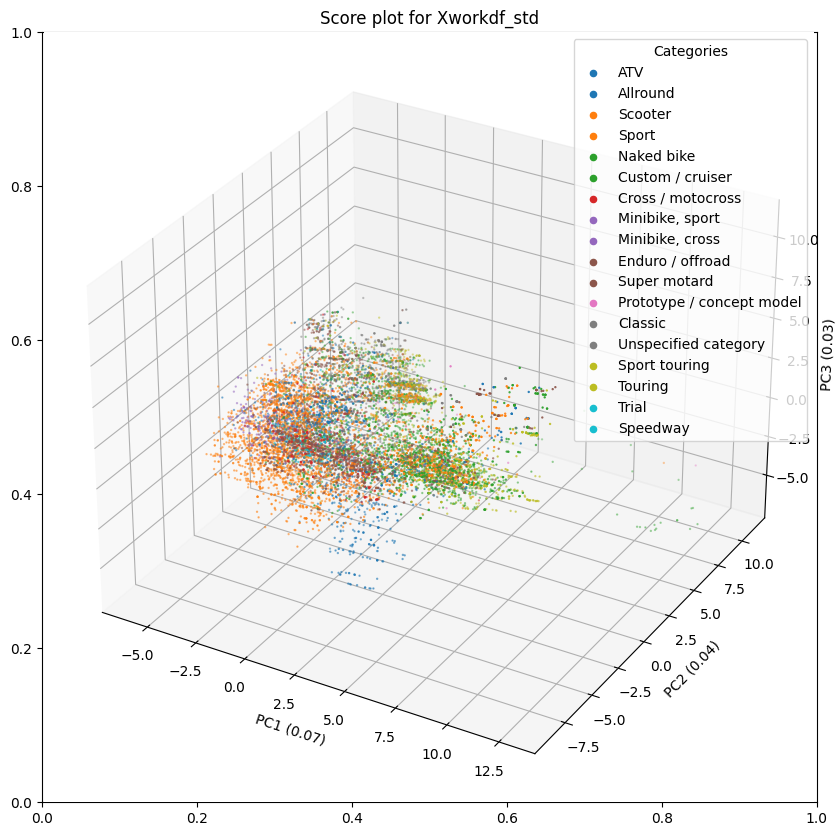

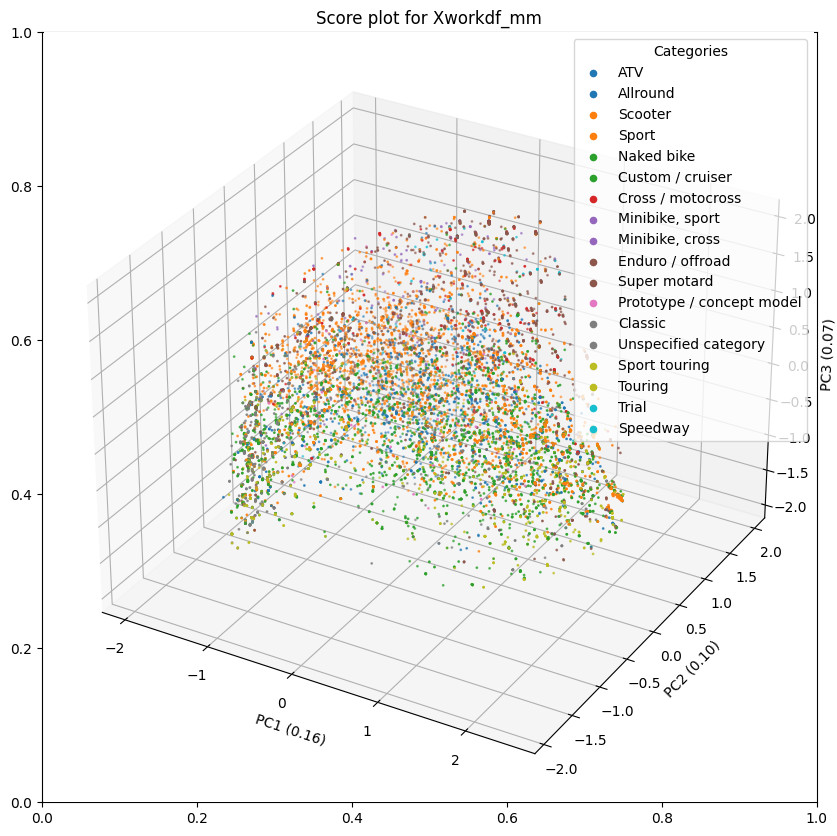

In [359]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# get the scores for the first num_dims PCs for both dataframes
if num_pc_std == 2:
    dims_std = 2
elif num_pc_std >= 3:
    dims_std = 3

stds = workdf['Category'].unique()
std_cmap = cm.get_cmap('tab10', len(stds))
std_colors = {stds[i]: std_cmap(i) for i in range(len(stds))}
scores_std = pca_std.transform(Xworkdf_std)[:, :dims_std]
workdf['color'] = [std_colors[t] for t in workdf['Category'].values]

# plot the scores for Xworkdf_std
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
if dims_std == 2:
    ax.scatter(scores_std[:, 0], scores_std[:, 1], c=workdf['color'], s=0.5)
    ax.set_xlabel('PC1 ({:.2f})'.format(pca_std.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.2f})'.format(pca_std.explained_variance_ratio_[1]))
else:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scores_std[:, 0], scores_std[:, 1], scores_std[:, 2], c=workdf['color'], s=0.5)
    ax.set_xlabel('PC1 ({:.2f})'.format(pca_std.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.2f})'.format(pca_std.explained_variance_ratio_[1]))
    ax.set_zlabel('PC3 ({:.2f})'.format(pca_std.explained_variance_ratio_[2]))
ax.set_title('Score plot for Xworkdf_std')
handles = []
labels = []
for category, color in std_colors.items():
    handles.append(ax.scatter([], [], c=color, s=20))
    labels.append(category)
ax.legend(handles, labels, loc='upper right', title='Categories')
plt.show()

# plot the scores for Xworkdf_mm
# Check number of dimensions
if num_pc_mm == 2:
    dims_mm = 2

elif num_pc_mm >= 3:
    dims_mm = 3

scores_mm = pca_mm.transform(Xworkdf_mm)[:, :dims_mm]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
if dims_mm == 2:
    ax.scatter(scores_mm[:, 0], scores_mm[:, 1], c=workdf['color'], s=1)
    ax.set_xlabel('PC1 ({:.2f})'.format(pca_mm.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.2f})'.format(pca_mm.explained_variance_ratio_[1]))
else:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scores_mm[:, 0], scores_mm[:, 1], scores_mm[:, 2], c=workdf['color'], s=1)
    ax.set_xlabel('PC1 ({:.2f})'.format(pca_mm.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2 ({:.2f})'.format(pca_mm.explained_variance_ratio_[1]))
    ax.set_zlabel('PC3 ({:.2f})'.format(pca_mm.explained_variance_ratio_[2]))
ax.set_title('Score plot for Xworkdf_mm')
ax.legend(handles, labels, loc='upper right', title='Categories')
plt.show()


Exercise 5 - (k-Means):

In [360]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range of k values to test
k_values = range(3, 11)

model_std=None
model_mm=None

# Iterate over each dataframe
for i, df in enumerate([Yworkdf_std, Yworkdf_mm]):
    print(f"Results for DataFrame {i+1}:\n")
    best_score = -1
    best_k = None
    for k in k_values:
        # Fit the k-means model
        model = KMeans(n_clusters=k, random_state=rs).fit(df)
        
        # Calculate the silhouette score
        score = silhouette_score(df, model.labels_)
        print(f"k = {k}, silhouette score = {score:.4f}")
        # Update the best score and k value if necessary
        if score > best_score:
            best_score = score
            best_k = k
            if i == 0:
                model_std = model
            else:
                model_mm = model
    
    print(f"Best value of k= {best_k}, silhouette score = {best_score:.4f} \n")


Results for DataFrame 1:



/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 3, silhouette score = 0.2686


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 4, silhouette score = 0.2936


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 5, silhouette score = 0.2642


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 6, silhouette score = 0.2780


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 7, silhouette score = 0.2690


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 8, silhouette score = 0.2716


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 9, silhouette score = 0.2713


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 10, silhouette score = 0.2673
Best value of k= 4, silhouette score = 0.2936 

Results for DataFrame 2:



/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 3, silhouette score = 0.3211


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 4, silhouette score = 0.3319


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 5, silhouette score = 0.3321


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 6, silhouette score = 0.3119


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 7, silhouette score = 0.2914


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 8, silhouette score = 0.2777


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 9, silhouette score = 0.2736


/Users/hadiibrahim/Dev/POLITO/Linear-Projects/PrincipalComponentsAnalysis/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 10, silhouette score = 0.2687
Best value of k= 5, silhouette score = 0.3321 



Exercise 6 - (Clusters and Centroid Interpretation and Visualization): 

Exercise 7 - Optional (Clusters and Centroids Evaluation):